# Gesture Recognition
please note this notebook has been executed in google colab

<a href='#section1'>Click Here to jump to Best Model</a><br>
<a href='#section2'>Click Here to jump to 2nd Best Model</a>

In [0]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio
import datetime
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image as imge

In [223]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [224]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1213991442127899050
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7036689785700214840
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9582048350181466328
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2374972587752065109
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


We set the random seed so that the results don't vary drastically.

In [0]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.compat.v1.set_random_seed(30)
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [0]:
train_doc = np.random.permutation(open('/content/drive/My Drive/data science/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/My Drive/data science/Project_data/val.csv').readlines())
batch_size = 25 #experiment with the batch size

In [227]:

len(train_doc)

663

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [228]:
image1 = imge.load_img(r'/content/drive/My Drive/data science/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png', target_size=(100,100,3))
np.array(image1)[:,:,0]                

array([[119, 121, 115, ..., 140, 137, 136],
       [125, 122, 120, ..., 137, 135, 132],
       [132, 134, 134, ..., 133, 135, 134],
       ...,
       [143, 105,  60, ...,  63,  69,  73],
       [103,  63,  44, ...,  62,  70,  75],
       [ 22,  21,  34, ...,  66,  71,  72]], dtype=uint8)

In [0]:
def load_batch_images(source_path, folder_list, batch, batch_size, t,validation):
    x=20
    y=100
    z=100
    img_idx = [x for x in range(10,30)]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imge.load_img(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], target_size=(y,z,3))
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
            batch_data[folder,idx,:,:,0] =np.array(image)[:,:,0]/127.5-1  #normalise and feed in the image
            batch_data[folder,idx,:,:,1] =np.array(image)[:,:,1]/127.5-1 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] =np.array(image)[:,:,2]/127.5-1 #normalise and feed in the image

                    
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [0]:
def generator(source_path, folder_list, batch_size, validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    batch_size_temp=batch_size
    while True:
        batch_size=batch_size_temp
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,validation)
            

        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,validation)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [232]:
curr_dt_time = datetime.datetime.now()
train_path = r'/content/drive/My Drive/data science/Project_data/train'
val_path = '/content/drive/My Drive/data science/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 3# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 3


<a id='section2'></a>

## Model 1 (model with 98% accuracy with 52 million trainable parameters)


In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3,3), padding='same',
                 input_shape=[20, 100, 100, 3]))
model.add(Activation('relu'))
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [234]:
rate = 0.001
optimiser = optimizers.Adam(lr=rate)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_59 (Conv3D)           (None, 20, 100, 100, 32)  2624      
_________________________________________________________________
activation_77 (Activation)   (None, 20, 100, 100, 32)  0         
_________________________________________________________________
conv3d_60 (Conv3D)           (None, 18, 98, 98, 32)    27680     
_________________________________________________________________
activation_78 (Activation)   (None, 18, 98, 98, 32)    0         
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, 9, 49, 49, 32)     0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 9, 49, 49, 32)     0         
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 9, 49, 49, 64)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [0]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [236]:
batch_data, batch_labels=next(train_generator)
batch_data.shape

Source path =  /content/drive/My Drive/data science/Project_data/train ; batch size = 25


(25, 20, 100, 100, 3)

In [0]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [0]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

**Please Note: 1st execute till here before executing any Models**

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [63]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Epoch 1/5
Source path =  /content/drive/My Drive/data science/Project_data/val ; batch size = 50
14/14 [==============================] - 14s 987ms/step - loss: 0.2102 - categorical_accuracy: 0.9857 - val_loss: 0.3224 - val_categorical_accuracy: 0.9800
Epoch 2/5
14/14 [==============================] - 89s 6s/step - loss: 0.2692 - categorical_accuracy: 0.9833 - val_loss: 0.3224 - val_categorical_accuracy: 0.9800
Epoch 3/5
14/14 [==============================] - 121s 9s/step - loss: 0.3385 - categorical_accuracy: 0.9790 - val_loss: 0.1612 - val_categorical_accuracy: 0.9900
Epoch 4/5
14/14 [==============================] - 144s 10s/step - loss: 0.3154 - categorical_accuracy: 0.9804 - val_loss: 0.1612 - val_categorical_accuracy: 0.9900
Epoch 5/5
14/14 [==============================] - 129s 9s/step - loss: 0.3385 - categorical_accuracy: 0.9790 - val_loss: 0.3224 - val_categorical_accuracy: 0.9800


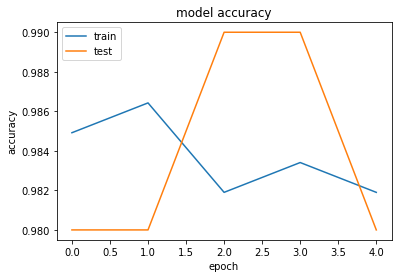

In [64]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### The model1 has preety good accuracy but very complex with 52 million tranable parameters

## Model 2 CNN3D 

model with reduced number of filters but adding more layers

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

#write your model here
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
nb_filters = [8,16,32,64]
nb_dense = [1000, 500, 5]

model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=[20, 100, 100, 3],
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))



In [103]:
optimiser ='adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 100, 100, 8)   32        
_________________________________________________________________
activation_31 (Activation)   (None, 20, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 10, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 50, 50, 16)    64        
_________________________________________________________________
activation_32 (Activation)   (None, 10, 50, 50, 16)   

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [104]:
history1=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1, 
                    initial_epoch=0)

Epoch 1/10
Source path =  /content/drive/My Drive/data science/Project_data/val ; batch size = 50
14/14 [==============================] - 8s 584ms/step - loss: 0.3108 - categorical_accuracy: 0.0832 - val_loss: 0.1612 - val_categorical_accuracy: 0.0100
Epoch 2/10
14/14 [==============================] - 4s 264ms/step - loss: 0.3154 - categorical_accuracy: 0.0043 - val_loss: 0.2129 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
14/14 [==============================] - 4s 261ms/step - loss: 0.1892 - categorical_accuracy: 0.0115 - val_loss: 2.3842e-09 - val_categorical_accuracy: 0.0200
Epoch 4/10
14/14 [==============================] - 4s 261ms/step - loss: 0.3616 - categorical_accuracy: 0.0014 - val_loss: 0.3224 - val_categorical_accuracy: 0.0000e+00
Epoch 5/10
14/14 [==============================] - 3s 237ms/step - loss: 0.3154 - categorical_accuracy: 0.0043 - val_loss: 0.3224 - val_categorical_accuracy: 0.0000e+00
Epoch 6/10
14/14 [==============================] - 116s 8s/step - 

<a id='section1'></a>

## model 3 CNN 3D(model with 98% accuracy with just 650,997 trainable parameters) Best and final Model

same model as above but reducing the neurons of dense layers

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

#write your model here
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
nb_filters = [8,16,32,64]
nb_dense = [1000, 500, 5]

        
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=[20, 100, 100, 3], padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
#model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [170]:
optimiser ='adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_47 (Conv3D)           (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 100, 100, 8)   32        
_________________________________________________________________
activation_61 (Activation)   (None, 20, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_48 (Conv3D)           (None, 10, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 50, 50, 16)    64        
_________________________________________________________________
activation_62 (Activation)   (None, 10, 50, 50, 16)  

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [171]:
history2=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,callbacks=callbacks_list,
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Epoch 1/10
Source path =  /content/drive/My Drive/data science/Project_data/val ; batch size = 50
14/14 [==============================] - 8s 584ms/step - loss: 0.2225 - categorical_accuracy: 0.9154 - val_loss: 0.3224 - val_categorical_accuracy: 0.9800

Epoch 00001: saving model to model_init_2020-03-0215_01_52.598937/model-00001-0.23400-0.91101-0.32236-0.98000.h5
Epoch 2/10
14/14 [==============================] - 4s 262ms/step - loss: 0.2692 - categorical_accuracy: 0.9833 - val_loss: 0.3224 - val_categorical_accuracy: 0.9800

Epoch 00002: saving model to model_init_2020-03-0215_01_52.598937/model-00002-0.21880-0.98643-0.32236-0.98000.h5
Epoch 3/10
14/14 [==============================] - 4s 266ms/step - loss: 0.3385 - categorical_accuracy: 0.9790 - val_loss: 0.1612 - val_categorical_accuracy: 0.9900

Epoch 00003: saving model to model_init_2020-03-0215_01_52.598937/model-00003-0.29173-0.98190-0.16118-0.99000.h5
Epoch 4/10
14/14 [==============================] - 4s 263ms/step - loss:

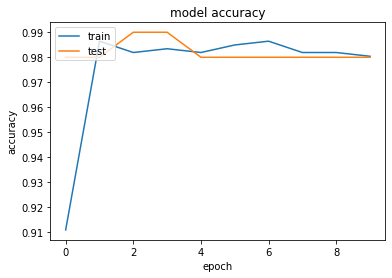

In [172]:
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### MODEL3 is the best model we could find with less number of trainable parameters

## model 4 CNN2D + GRU(RNN)

In [192]:

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU

model = Sequential()
model.add(TimeDistributed(Conv2D(64, (3, 3)), input_shape=[20, 100, 100, 3]))
print(model.output_shape)

model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
print(model.output_shape)
model.add(TimeDistributed(Flatten()))
model.add(Dense(50))
print(model.output_shape)

model.add(GRU(10))

print(model.output_shape)
model.add(Dense(5, activation='softmax'))

(None, 20, 98, 98, 64)

(None, 20, 49, 49, 64)
(None, 20, 50)
(None, 10)


In [193]:
optimiser ='adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 98, 98, 64)    1792      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 49, 49, 64)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 153664)        0         
_________________________________________________________________
dense_32 (Dense)             (None, 20, 50)            7683250   
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                1830      
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 55        
Total params: 7,686,927
Trainable params: 7,686,927
Non-trainable params: 0
___________________________________________

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [194]:
history3=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Epoch 1/10
Source path =  /content/drive/My Drive/data science/Project_data/val ; batch size = 50
14/14 [==============================] - 13s 910ms/step - loss: 0.0561 - categorical_accuracy: 0.9819 - val_loss: 0.0408 - val_categorical_accuracy: 0.9800
Epoch 2/10
14/14 [==============================] - 113s 8s/step - loss: 0.0459 - categorical_accuracy: 0.4259 - val_loss: 0.0581 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
14/14 [==============================] - 122s 9s/step - loss: 0.0494 - categorical_accuracy: 0.0029 - val_loss: 0.0329 - val_categorical_accuracy: 0.0000e+00
Epoch 4/10
14/14 [==============================] - 102s 7s/step - loss: 0.0507 - categorical_accuracy: 0.0014 - val_loss: 0.0663 - val_categorical_accuracy: 0.0000e+00
Epoch 5/10
14/14 [==============================] - 121s 9s/step - loss: 0.0452 - categorical_accuracy: 0.0067 - val_loss: 0.0302 - val_categorical_accuracy: 0.0000e+00
Epoch 6/10
14/14 [==============================] - 79s 6s/step - loss

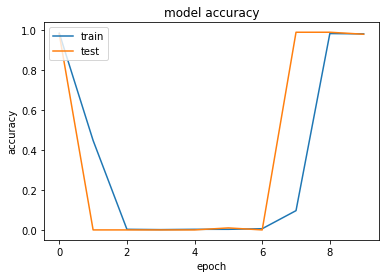

In [195]:
plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model 4 : we got some good models with 98% accuracy but the model is very unstable

## Model 5 (transfer learning CNN and GRU)

In [242]:
from keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D

def get_model():
    
    base_model = VGG16(weights='imagenet', include_top=False)
    
    # freeze the layers in base model
    #for layer in base_model.layers:
     #   layer.trainable = False
        
    # Get the output from the base model 
    base_model_ouput = base_model.output
    print(base_model_ouput)


   
    print("base_model.input",base_model.input)
    input_layer = Input(shape=[20, 100, 100, 3])
    x = TimeDistributed(base_model)(input_layer)
    
    
    #x = TimeDistributed(GlobalAveragePooling2D())(x)
    x=TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
    
    x=TimeDistributed(Flatten())(x)
    x=GRU(512)(x)
 
    x = Dense(512, activation='relu')(x)
  
    x = Dense(5, activation='softmax', name='fcnew')(x)
    
    model = Model(inputs=input_layer, outputs=x)

    return model
model=get_model()

Tensor("block5_pool_2/MaxPool:0", shape=(?, ?, ?, 512), dtype=float32)
base_model.input Tensor("input_5:0", shape=(?, ?, ?, 3), dtype=float32)


In [243]:
optimiser ='adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 20, 100, 100, 3)   0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 20, 512)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 512)               1574400   
_________________________________________________________________
dense_40 (Dense)             (None, 512)               262656    
_________________________________________________________________
fcnew (Dense)                (None, 5)                 2565

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [245]:
history4=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Epoch 1/10
Source path =  /content/drive/My Drive/data science/Project_data/val ; batch size = 25
Source path =  /content/drive/My Drive/data science/Project_data/train ; batch size = 25
27/27 [==============================] - 221s 8s/step - loss: 0.0978 - categorical_accuracy: 0.1127 - val_loss: 0.0537 - val_categorical_accuracy: 0.0200
Epoch 2/10
27/27 [==============================] - 138s 5s/step - loss: 0.1186 - categorical_accuracy: 0.2876 - val_loss: 0.0686 - val_categorical_accuracy: 0.0200
Epoch 3/10
27/27 [==============================] - 141s 5s/step - loss: 0.0943 - categorical_accuracy: 0.0117 - val_loss: 0.0678 - val_categorical_accuracy: 0.0100
Epoch 4/10
27/27 [==============================] - 139s 5s/step - loss: 0.0788 - categorical_accuracy: 0.2876 - val_loss: 0.0561 - val_categorical_accuracy: 0.0200
Epoch 5/10
27/27 [==============================] - 171s 6s/step - loss: 0.0710 - categorical_accuracy: 0.0072 - val_loss: 0.0603 - val_categorical_accuracy: 0.0100

**This model didn't provide good accuracy**

## Model 3 is the best model with only 6 lacs trainable parameters 
***please Note:In order to get the same accuracy batch size should be 50 for all models***